In [1]:
rm -rf sample_data/

In [2]:
pwd

'/content'

#### upload wheat_bangalore.csv to /content folder

In [3]:
ls

Wheat_Bangalore.csv


In [8]:
pip install statsmodels --upgrade

     |████████████████████████████████| 9.5MB 6.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [54]:
# import statements
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime

In [55]:
# date format in data
dateparser = lambda x: datetime.strptime(x, '%Y-%m-%d')

In [56]:
# read data from csv file
series = pd.read_csv('Wheat_Bangalore.csv', usecols=['Date','MeanPrice(Rs./Quintal)'],index_col=0, parse_dates=['Date'], date_parser=dateparser, squeeze=True)
series

Date
2002-01-01    1100
2002-06-01    1200
2002-07-01    1184
2002-08-01    1176
2002-11-01    1150
              ... 
2019-06-01    2900
2019-07-01    2900
2019-08-01    2900
2019-11-01    3014
2019-12-01    2700
Name: MeanPrice(Rs./Quintal), Length: 106, dtype: int64

In [57]:
# differencing functions
def difference(dataset, interval=1):
  return series.diff(interval)

def inverse_difference(history, y_predicted, interval):
  return y_predicted + history[-interval]

In [58]:
# difference and split dataset
raw_values = series.values
X = difference(raw_values,1)  #difference series degree = 1, check "undertanding timeseries Data.ipynb"

# keeping last 7 values for testing, rest for training 
train, test = X[1:len(X)-7], X[len(X)-7:]
print(f"train\n: {train}\n")
print(f"test\n: {test}\n")

train
: Date
2002-06-01    100.0
2002-07-01    -16.0
2002-08-01     -8.0
2002-11-01    -26.0
2002-12-01      0.0
              ...  
2018-01-01      0.0
2018-06-01    -87.0
2018-07-01    -13.0
2018-08-01      0.0
2018-11-01     50.0
Name: MeanPrice(Rs./Quintal), Length: 98, dtype: float64

test
: Date
2018-12-01      0.0
2019-01-01      0.0
2019-06-01    150.0
2019-07-01      0.0
2019-08-01      0.0
2019-11-01    114.0
2019-12-01   -314.0
Name: MeanPrice(Rs./Quintal), dtype: float64



In [59]:
# train auto-regressor
model = AutoReg(train, lags=1) #check ACF plot to see why lags=1 is taken
model_fit = model.fit()
print(f"Coefficients:\n{model_fit.params}")

Coefficients:
intercept                    20.133724
MeanPrice(Rs./Quintal).L1    -0.251857
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


In [60]:
# make predictions
inv_predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False).to_list()
predictions = list()
actual = list()

for i in range(1,len(inv_predictions)):
  predictions.append(inverse_difference(raw_values,inv_predictions[i],len(train)-len(test)+i+1))
  actual.append(inverse_difference(raw_values, test[i], len(train)-len(test)+i+1))


for i in range(len(predictions)):
  print("predicted = %f expected = %f"%(predictions[i],actual[i]))

predicted = 1081.234503 expected = 1063.000000
predicted = 1365.541236 expected = 1500.000000
predicted = 1248.219555 expected = 1232.000000
predicted = 1116.048715 expected = 1100.000000
predicted = 1116.091742 expected = 1214.000000
predicted = 1116.080906 expected = 786.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


In [61]:
# Error calculation
rmse = sqrt(mean_squared_error(actual,predictions))
print(f"RMSE : {rmse}")

RMSE : 151.36695072888486


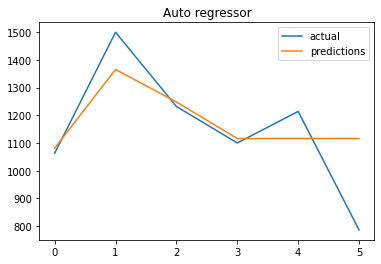

In [62]:
plt.title("Auto regressor")
plt.plot(actual, label="actual")
plt.plot(predictions, label="predictions")
plt.legend()
plt.show()

-----------------------------------------------------------------

Try Yule walker estimates to get coefficients (try on differenced series)